In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

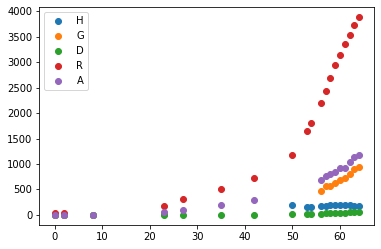

In [3]:
time = [0,2,8,23,27,35,42,50,53,54,56,57,58, 59,60,61,62,63, 64]
S = [141105] + [None]*(len(time)-1)
R = [54874] + [None]*(len(time)-1)
H = [0, 0, 0, 11, None, None, None, 189, 147, 147, 183, 176, 193,  190, 197, 189, 191, 183,  174]
G = [4, 7, 7, 37, None, None, None, None, None, None, 471, 558, 572,  620, 676, 727, 809, 893,  949]
D = [0, 0, 1, 1, 3, 3, 6, 16, 20, 22, 25, 32, 33,  39, 42, 44, 48, 53,  55]
cE = [28, 36, None, 169, 314, 513, 716, 1174, 1644, 1797, 2194, 2437, 2686,  2936, 3149, 3357, 3530, 3728,  3881]
cH = [4, 7, 8, 49, 91, 195, 290, None, None, None, 679, 766, 798,  849, 915, 915, 1048, 1129,  1178]

plt.plot(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

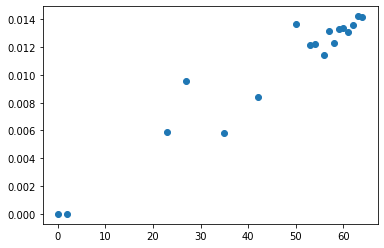

In [4]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [5]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 2
data_time = time[start:]
data_pd = data_pd[start:,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 63*2,
    "basis_number": 31,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.5],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        [1]*len(data_time)
    ],
    "regularisation_value": copy(p0),
}

In [6]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [7]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [8]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e1

In [9]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     5572

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

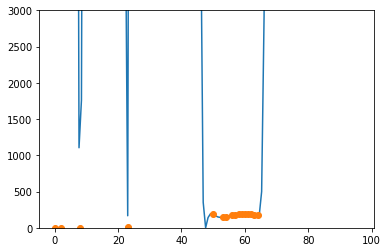

In [10]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [11]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     5572

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8599454e+02 0.00e+00 3.92e-03  -8.6 2.73e+03 -14.6 1.00e+00 1.00e+00h  1
 210  1.8599453e+02 0.00e+00 1.39e-02  -8.6 2.43e+02 -12.1 1.00e+00 8.11e-02h  1
 220  1.8599451e+02 0.00e+00 9.40e-02  -8.6 1.89e+07    -  1.95e-04 4.25e-05f  3
 230  1.8599449e+02 0.00e+00 5.99e-02  -8.6 6.65e+02    -  7.34e-01 3.62e-01h  1
 240  1.8599449e+02 0.00e+00 8.23e-04  -8.6 7.38e+01 -13.5 1.00e+00 1.00e+00h  1
 250  1.8599448e+02 0.00e+00 2.82e-04  -8.6 1.28e+00  -8.7 2.95e-01 1.00e+00h  1
 260  1.8599448e+02 0.00e+00 2.21e-02  -8.6 2.62e+02 -13.5 5.62e-01 1.00e+00h  1
 270  1.8599447e+02 0.00e+00 6.78e-02  -8.6 7.08e+02 -13.7 1.00e+00 5.00e-01h  2
 280  1.8599446e+02 0.00e+00 1.62e-03  -8.6 6.37e+00  -9.5 1.00e+00 1.00e+00h  1
 290  1.8599445e+02 0.00e+00 1.72e-02  -8.6 1.64e+03 -14.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.8599444e+02 0.00e+00

  20  1.8707448e+02 0.00e+00 3.02e+00  -3.8 1.01e+04    -  9.29e-01 7.25e-01f  1
  30  1.8705313e+02 0.00e+00 1.88e-02  -5.7 3.49e+02  -9.2 1.00e+00 3.88e-01f  1
  40  1.8703463e+02 0.00e+00 5.60e-02  -5.7 2.84e+03 -12.2 1.00e+00 3.95e-02f  1
  50  1.8703290e+02 0.00e+00 1.37e-02  -5.7 8.80e+02 -12.9 1.00e+00 1.00e+00f  1
  60  1.8703257e+02 0.00e+00 3.22e-01  -5.7 1.03e+04    -  1.00e+00 1.17e-01h  4
  70  1.8703246e+02 0.00e+00 2.19e-01  -5.7 1.38e+04    -  1.00e+00 7.22e-02h  4
  80  1.8703241e+02 0.00e+00 4.72e-01  -5.7 2.51e+03    -  1.00e+00 5.00e-01h  2
  90  1.8703230e+02 0.00e+00 1.49e-01  -5.7 3.63e+03    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8703227e+02 0.00e+00 2.09e-02  -5.7 2.59e+02    -  1.00e+00 1.00e+00h  1
 110  1.8703208e+02 0.00e+00 2.41e-01  -8.6 1.31e+03 -13.7 6.59e-01 1.00e+00f  1
 120  1.8703200e+02 0.00e+00 7.30e-02  -8.6 2.32e+03 -13.9 1.00e+00 1.00e+00f  1
 130  1.8703193e+02 0.00e+00

   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8982679e+02 0.00e+00 2.97e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.9303982e+02 0.00e+00 1.90e+00  -1.0 3.97e+03    -  7.27e-01 1.00e+00f  1
  20  1.8888552e+02 0.00e+00 1.97e+00  -3.8 5.38e+03    -  5.50e-01 1.00e+00f  1
  30  1.8884453e+02 0.00e+00 1.80e-03  -5.7 1.68e+02  -8.8 1.00e+00 1.00e+00f  1
  40  1.8883301e+02 0.00e+00 2.25e-01  -5.7 2.15e+03 -12.6 1.00e+00 1.00e+00f  1
  50  1.8882820e+02 0.00e+00 7.26e-02  -5.7 2.30e+02 -10.2 1.00e+00 7.34e-03f  8
  60  1.8882569e+02 0.00e+00 1.10e-01  -5.7 7.77e+02 -12.2 1.00e+00 1.00e+00f  1
  70  1.8882510e+02 0.00e+00 9.56e-02  -5.7 4.16e+02 -12.0 1.00e+00 1.00e+00f  1
  80  1.8882484e+02 0.00e+00 8.12e-02  -5.7 2.84e+02 -12.6 1.00e+00 1.00e+00h  1
  90  1.8882471e+02 0.00e+00 3.86e-01  -5.7 1.94e+03    -  1.

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9221789e+02 0.00e+00 3.06e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.9617144e+02 0.00e+00 1.32e+01  -1.0 3.25e+03    -  7.58e-01 1.00e+00f  1
  20  1.9179610e+02 0.00e+00 2.40e+01  -2.5 2.44e+04    -  9.66e-01 5.00e-01f  2
  30  1.9120955e+02 0.00e+00 5.27e-01  -5.7 2.56e+03  -9.7 5.96e-01 4.62e-01f  1
  40  1.9105374e+0

  70  1.9272479e+02 0.00e+00 2.06e-01  -3.8 8.81e+02 -12.6 1.00e+00 1.00e+00f  1
  80  1.9272488e+02 0.00e+00 5.65e-02  -3.8 6.21e+02    -  1.00e+00 1.00e+00h  1
  90  1.9270227e+02 0.00e+00 1.82e-01  -5.7 1.65e+03 -12.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9270153e+02 0.00e+00 8.97e-02  -5.7 1.13e+03 -13.4 1.00e+00 1.00e+00h  1
 110  1.9270102e+02 0.00e+00 2.51e-01  -5.7 7.22e+02 -13.0 1.00e+00 1.00e+00f  1
 120  1.9269993e+02 0.00e+00 7.99e-02  -5.7 2.17e+02 -11.9 1.00e+00 1.00e+00f  1
 130  1.9269719e+02 0.00e+00 3.62e-01  -5.7 9.57e+02 -12.2 1.00e+00 1.00e+00f  1
 140  1.9269206e+02 0.00e+00 6.03e-02  -5.7 7.83e+02 -11.5 1.00e+00 1.00e+00f  1
 150  1.9268974e+02 0.00e+00 3.30e-01  -5.7 3.06e+03 -12.6 1.00e+00 5.00e-01f  2
 160  1.9268880e+02 0.00e+00 8.29e-02  -5.7 4.44e+02 -12.8 1.00e+00 1.00e+00f  1
 170  1.9268841e+02 0.00e+00 2.16e-01  -5.7 5.82e+03 -14.3 1.00e+00 1.00e+00f  1
 180  1.9268804e+02 0.00e+00

  40  1.9385875e+02 0.00e+00 4.74e+00  -5.7 4.20e+03 -11.4 1.00e+00 1.00e+00f  1
  50  1.9384501e+02 0.00e+00 2.09e-01  -5.7 1.55e+03 -11.6 1.00e+00 1.00e+00f  1
  60  1.9382874e+02 0.00e+00 9.23e+00  -5.7 9.49e+03 -11.0 3.24e-02 4.02e-02f  4
  70  1.9382459e+02 0.00e+00 2.55e-01  -5.7 1.26e+03 -13.0 1.00e+00 1.00e+00f  1
  80  1.9382391e+02 0.00e+00 7.94e-02  -5.7 6.22e+02 -12.4 1.00e+00 1.00e+00f  1
  90  1.9382339e+02 0.00e+00 6.50e-01  -5.7 9.89e+02 -12.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9382276e+02 0.00e+00 3.78e-01  -5.7 3.38e+02 -11.5 1.00e+00 1.00e+00f  1
 110  1.9382214e+02 0.00e+00 9.33e-02  -5.7 1.53e+02 -10.9 1.00e+00 1.00e+00f  1
 120  1.9382132e+02 0.00e+00 8.99e-01  -5.7 4.72e+02 -12.9 1.00e+00 1.00e+00f  1
 130  1.9382060e+02 0.00e+00 2.64e-02  -5.7 2.56e+01  -9.6 1.00e+00 1.00e+00h  1
 140  1.9381977e+02 0.00e+00 4.01e-02  -5.7 3.04e+03 -13.4 1.00e+00 1.00e+00f  1
 150  1.9381877e+02 0.00e+00

  40  1.9486165e+02 0.00e+00 1.52e+00  -5.7 1.44e+05    -  7.79e-02 1.49e-02f  3
  50  1.9485754e+02 0.00e+00 9.97e-01  -5.7 4.61e+02  -9.8 1.00e+00 2.50e-01f  3
  60  1.9485423e+02 0.00e+00 1.19e+00  -5.7 1.84e+04 -11.0 4.07e-02 9.24e-03f  4
  70  1.9485136e+02 0.00e+00 1.46e+00  -5.7 3.98e+02 -11.2 1.00e+00 1.00e+00f  1
  80  1.9484894e+02 0.00e+00 8.07e-01  -5.7 5.21e+02 -12.4 1.00e+00 1.00e+00f  1
  90  1.9484744e+02 0.00e+00 6.57e-01  -5.7 1.04e+04 -12.6 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9484664e+02 0.00e+00 1.68e+00  -5.7 1.80e+03 -12.9 1.00e+00 1.00e+00f  1
 110  1.9484629e+02 0.00e+00 1.66e+00  -5.7 1.64e+04    -  1.00e+00 9.33e-02f  4
 120  1.9484608e+02 0.00e+00 1.52e-01  -5.7 4.19e+02    -  1.00e+00 1.00e+00h  1
 130  1.9484583e+02 0.00e+00 3.66e-02  -8.6 4.59e+04    -  8.16e-01 1.48e-01h  1
 140  1.9484583e+02 0.00e+00 1.06e-08  -9.0 1.83e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9657092e+02 0.00e+00 1.39e+00  -5.7 2.78e+02 -10.6 1.00e+00 1.00e+00f  1
 110  1.9656819e+02 0.00e+00 1.81e-01  -5.7 1.14e+03 -12.7 1.00e+00 5.00e-01f  2
 120  1.9656710e+02 0.00e+00 9.22e-02  -5.7 9.28e+01 -10.2 1.00e+00 1.00e+00h  1
 130  1.9656670e+02 0.00e+00 1.02e-02  -5.7 1.85e+01  -9.5 1.00e+00 1.00e+00h  1
 140  1.9656591e+02 0.00e+00 1.68e+00  -5.7 5.22e+05    -  4.10e-02 2.15e-03f  4
 150  1.9656521e+02 0.00e+00 3.05e-01  -5.7 1.16e+03    -  1.00e+00 1.00e+00f  1
 160  1.9656501e+02 0.00e+00 8.83e-04  -5.7 2.20e+01    -  1.00e+00 1.00e+00h  1
 170  1.9656475e+02 0.00e+00 5.42e-05  -8.6 2.01e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 175

                                   (scaled)                 (unscaled)
Objective...............:   1.9656475149578338e+02    1.9656475149578338e+02
Dual infeasibility......:   2.6862108160062850e-10    2.6862108160062850e-10
Constraint vio

  30  1.9847914e+02 0.00e+00 4.31e+00  -5.7 2.08e+03 -10.2 6.60e-01 4.07e-01f  1
  40  1.9836076e+02 0.00e+00 9.71e-01  -5.7 2.01e+03 -10.5 3.65e-01 5.57e-01f  1
  50  1.9827136e+02 0.00e+00 2.15e+00  -5.7 8.35e+02 -10.7 7.13e-01 5.00e-01f  2
  60  1.9826323e+02 0.00e+00 4.65e-01  -5.7 8.00e+02  -9.6 3.37e-02 3.73e-01f  1
  70  1.9825619e+02 0.00e+00 6.32e-01  -5.7 2.76e+02 -10.3 8.59e-01 1.00e+00f  1
  80  1.9824580e+02 0.00e+00 4.68e+00  -5.7 5.11e+02 -11.4 1.00e+00 1.00e+00f  1
  90  1.9823504e+02 0.00e+00 4.89e+00  -5.7 4.83e+02 -11.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9822513e+02 0.00e+00 3.30e+00  -5.7 4.01e+02 -11.0 1.00e+00 1.00e+00f  1
 110  1.9821733e+02 0.00e+00 6.93e+00  -5.7 3.25e+03 -12.2 1.00e+00 5.00e-01f  2
 120  1.9821418e+02 0.00e+00 1.01e+00  -5.7 7.64e+02 -11.6 1.00e+00 1.00e+00f  1
 130  1.9821295e+02 0.00e+00 2.23e-02  -5.7 3.01e+02 -11.3 1.00e+00 1.00e+00f  1
 140  1.9821155e+02 0.00e+00

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0328764e+02 0.00e+00 2.63e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.0885645e+02 0.00e+00 9.99e+01  -1.0 7.10e+02    -  7.45e-01 1.00e+00f  1
  20  2.0048959e+02 0.00e+00 2.79e-01  -5.7 1.00e+01  -5.4 5.82e-01 1.00e+00f  1
  30  2.0029558e+02 0.00e+00 6.99e+00  -5.7 3.68e+02 -10.2 8.29e-01 1.00e+00f  1
  40  2.0025877e+0

  20  2.0693190e+02 0.00e+00 6.44e+02  -1.7 1.42e+04    -  7.54e-01 5.00e-01f  2
  30  2.0602119e+02 0.00e+00 1.03e+01  -1.7 4.41e+02  -8.3 1.00e+00 1.00e+00f  1
  40  2.0620617e+02 0.00e+00 3.65e+02  -1.7 1.22e+04    -  1.00e+00 2.50e-01f  3
  50  2.0619516e+02 0.00e+00 1.91e+01  -1.7 3.15e+03  -9.9 1.00e+00 1.00e+00f  1
  60  2.0630624e+02 0.00e+00 1.17e+01  -1.7 1.18e+03 -10.1 1.00e+00 1.00e+00f  1
  70  2.0308667e+02 0.00e+00 8.17e+01  -3.8 2.45e+04    -  6.99e-01 2.32e-01f  2
  80  2.0296542e+02 0.00e+00 7.30e+00  -3.8 1.44e+03 -11.2 1.00e+00 1.00e+00f  1
  90  2.0293479e+02 0.00e+00 2.26e+01  -3.8 6.83e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0289535e+02 0.00e+00 8.73e+00  -3.8 5.50e+02 -10.7 1.00e+00 1.00e+00f  1
 110  2.0278981e+02 0.00e+00 7.84e+01  -3.8 1.14e+05    -  2.33e-01 8.82e-02f  3
 120  2.0249349e+02 0.00e+00 4.84e+01  -3.8 1.23e+03 -10.7 1.00e+00 1.00e+00f  1
 130  2.0246841e+02 0.00e+00

 220  2.0339077e+02 0.00e+00 6.50e+00  -3.8 2.62e+02 -11.2 1.00e+00 1.00e+00f  1
 230  2.0338104e+02 0.00e+00 2.69e+01  -3.8 1.78e+05    -  2.11e-01 1.06e-02f  4
 240  2.0337435e+02 0.00e+00 1.92e+00  -3.8 4.58e+02 -11.2 1.00e+00 1.00e+00f  1
 250  2.0336414e+02 0.00e+00 3.04e+01  -3.8 6.00e+04    -  4.30e-01 2.76e-02f  4
 260  2.0335578e+02 0.00e+00 1.31e+01  -3.8 1.08e+04    -  1.00e+00 2.50e-01f  3
 270  2.0334397e+02 0.00e+00 1.61e+01  -3.8 8.11e+03    -  1.00e+00 2.50e-01f  3
 280  2.0333653e+02 0.00e+00 6.45e+00  -3.8 5.57e+04    -  2.47e-01 1.02e-02f  5
 290  2.0332614e+02 0.00e+00 3.78e+00  -3.8 6.24e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.0332055e+02 0.00e+00 3.93e-02  -3.8 3.40e+01    -  1.00e+00 1.00e+00h  1
 310  2.0329963e+02 0.00e+00 3.36e-01  -5.7 5.02e+01  -9.1 1.00e+00 1.00e+00f  1
 320  2.0329772e+02 0.00e+00 1.61e-04  -5.7 7.95e-01  -8.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 3

  90  2.0767076e+02 0.00e+00 5.99e+01  -3.8 4.36e+03 -11.5 3.90e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0753332e+02 0.00e+00 8.80e+00  -3.8 3.92e+02 -10.0 1.00e+00 1.00e+00f  1
 110  2.0685358e+02 0.00e+00 3.01e+01  -3.8 1.43e+03 -10.3 1.00e+00 1.00e+00f  1
 120  2.0664687e+02 0.00e+00 1.57e+00  -3.8 5.03e+02 -10.5 1.00e+00 1.00e+00f  1
 130  2.0664336e+02 0.00e+00 8.31e+00  -3.8 1.61e+03 -10.7 4.21e-01 2.50e-01f  3
 140  2.0664056e+02 0.00e+00 1.10e+01  -3.8 3.40e+02 -10.4 1.00e+00 1.00e+00f  1
 150  2.0663714e+02 0.00e+00 2.30e+00  -3.8 1.05e+03 -11.6 1.00e+00 1.00e+00f  1
 160  2.0663169e+02 0.00e+00 8.72e+00  -3.8 3.67e+03    -  1.00e+00 5.00e-01f  2
 170  2.0662502e+02 0.00e+00 9.56e+00  -3.8 1.56e+04 -11.2 2.64e-02 2.40e-02f  6
 180  2.0661479e+02 0.00e+00 9.30e+00  -3.8 1.11e+03 -10.0 3.86e-01 2.50e-01f  3
 190  2.0660226e+02 0.00e+00 1.53e+01  -3.8 5.19e+02  -9.8 8.58e-01 5.00e-01f  2
iter    objective    inf_pr 

  50  2.1074935e+02 0.00e+00 7.21e+00  -2.5 6.33e+01  -7.9 1.00e+00 1.00e+00f  1
  60  2.1079806e+02 0.00e+00 2.21e+01  -2.5 3.32e+02  -9.3 1.00e+00 1.00e+00f  1
  70  2.1084917e+02 0.00e+00 3.68e+01  -2.5 2.37e+03    -  1.00e+00 5.00e-01f  2
  80  2.1087552e+02 0.00e+00 5.90e+00  -2.5 1.65e+03    -  1.00e+00 1.00e+00f  1
  90  2.1090906e+02 0.00e+00 2.18e+01  -2.5 8.39e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1093536e+02 0.00e+00 4.27e+00  -2.5 1.74e+02    -  1.00e+00 1.00e+00f  1
 110  2.1094946e+02 0.00e+00 1.12e-01  -2.5 2.76e+01    -  1.00e+00 1.00e+00h  1
 120  2.1063106e+02 0.00e+00 3.72e+01  -3.8 4.46e+02 -10.6 1.00e+00 1.00e+00f  1
 130  2.1058738e+02 0.00e+00 7.30e+00  -3.8 3.42e+02 -10.9 1.00e+00 1.00e+00f  1
 140  2.1054924e+02 0.00e+00 1.50e+01  -3.8 3.52e+02  -9.8 1.00e+00 1.00e+00f  1
 150  2.1048946e+02 0.00e+00 1.99e+01  -3.8 3.98e+02 -10.9 1.00e+00 1.00e+00f  1
 160  2.1041461e+02 0.00e+00

Solving for p=0.0032745491628777285
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     5572

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

 430  2.1998520e+02 0.00e+00 7.40e+00  -2.5 2.16e+02    -  1.00e+00 5.00e-01f  2
 440  2.1961161e+02 0.00e+00 1.11e+02  -3.8 6.34e+02  -9.7 1.00e+00 3.06e-01f  2
 450  2.1952832e+02 0.00e+00 1.02e+01  -3.8 1.30e+02  -9.0 1.00e+00 1.00e+00f  1
 460  2.1949942e+02 0.00e+00 4.41e+00  -3.8 6.77e+01  -8.4 1.00e+00 1.00e+00f  1
 470  2.1945390e+02 0.00e+00 4.57e-01  -3.8 1.96e+01  -7.7 1.00e+00 1.00e+00f  1
 480  2.1940603e+02 0.00e+00 1.80e-02  -3.8 8.65e+00  -7.1 1.00e+00 1.00e+00f  1
 490  2.1935911e+02 0.00e+00 1.14e+00  -3.8 1.30e+01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.1930671e+02 0.00e+00 7.70e-02  -3.8 1.41e+01  -7.6 1.00e+00 1.00e+00f  1
 510  2.1926412e+02 0.00e+00 2.45e-01  -5.7 1.18e+01  -7.4 1.00e+00 1.00e+00f  1
 520  2.1920725e+02 0.00e+00 1.75e+00  -5.7 6.04e+01  -8.5 1.00e+00 1.00e+00f  1
 530  2.1914146e+02 0.00e+00 5.72e-01  -5.7 8.21e+01  -8.8 1.00e+00 1.00e+00f  1
 540  2.1906158e+02 0.00e+00

 480  2.2384026e+02 0.00e+00 1.25e-02  -3.8 2.05e+00  -6.5 1.00e+00 1.00e+00f  1
 490  2.2376671e+02 0.00e+00 1.40e+00  -3.8 1.50e+01  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.2366799e+02 0.00e+00 2.96e+02  -3.8 1.17e+03 -10.2 1.00e+00 1.00e+00f  1
 510  2.2356049e+02 0.00e+00 1.42e-01  -3.8 3.98e+00  -6.4 1.00e+00 1.00e+00f  1
 520  2.2350417e+02 0.00e+00 1.25e+01  -3.8 2.16e+02  -8.8 1.00e+00 1.00e+00f  1
 530  2.2342103e+02 0.00e+00 2.51e-01  -3.8 5.48e+01  -8.1 1.00e+00 1.00e+00f  1
 540  2.2334410e+02 0.00e+00 4.24e-02  -3.8 2.47e+01  -7.8 1.00e+00 1.00e+00f  1
 550  2.2331335e+02 0.00e+00 4.80e+00  -3.8 1.95e+03    -  1.00e+00 1.00e+00f  1
 560  2.2330043e+02 0.00e+00 1.11e-01  -5.7 2.00e+04    -  1.00e+00 1.00e+00f  1
 570  2.2329996e+02 0.00e+00 3.14e-03  -8.6 1.03e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 572

                                   (scaled)                 (unscaled)
Object

 550  2.2884975e+02 0.00e+00 2.84e+00  -3.8 7.65e+01 -10.6 1.00e+00 1.00e+00f  1
 560  2.2883954e+02 0.00e+00 2.39e+00  -5.7 1.55e+02 -11.5 9.91e-01 5.16e-01f  1
 570  2.2883722e+02 0.00e+00 3.36e-03  -8.6 3.96e+03    -  1.00e+00 5.83e-01f  1

Number of Iterations....: 573

                                   (scaled)                 (unscaled)
Objective...............:   2.2883721734054049e+02    2.2883721734054049e+02
Dual infeasibility......:   1.8660013434871153e-09    1.8660013434871153e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8098655002067283e-09    2.8098655002067283e-09
Overall NLP error.......:   2.8098655002067283e-09    2.8098655002067283e-09


Number of objective function evaluations             = 1101
Number of objective gradient evaluations             = 574
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1101
Number of equality constraint J

 280  2.4806889e+02 0.00e+00 1.46e+01  -2.5 6.89e+01  -6.2 1.00e+00 1.00e+00f  1
 290  2.4729897e+02 0.00e+00 5.88e+00  -2.5 2.45e+01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.4679638e+02 0.00e+00 1.35e+01  -3.8 4.84e+02  -8.4 1.00e+00 1.00e+00f  1
 310  2.4669010e+02 0.00e+00 5.19e+00  -3.8 2.95e+03 -10.4 1.00e+00 1.00e+00f  1
 320  2.4624016e+02 0.00e+00 4.66e-01  -3.8 5.96e+00  -6.2 1.00e+00 1.00e+00f  1
 330  2.4576526e+02 0.00e+00 1.67e+01  -3.8 2.13e+03 -10.0 1.00e+00 1.00e+00f  1
 340  2.4508297e+02 0.00e+00 9.11e-01  -3.8 1.84e+01  -6.7 1.00e+00 1.00e+00f  1
 350  2.4429486e+02 0.00e+00 6.50e-01  -3.8 3.60e+01  -6.9 1.00e+00 1.00e+00f  1
 360  2.4373627e+02 0.00e+00 9.96e+00  -3.8 6.66e+03    -  1.00e+00 2.49e-01f  3
 370  2.4370507e+02 0.00e+00 3.00e-01  -3.8 8.61e+03    -  1.00e+00 5.00e-01f  2
 380  2.4369694e+02 0.00e+00 3.10e-02  -5.7 5.32e+00 -10.1 1.00e+00 1.00e+00f  1
 390  2.4369618e+02 0.00e+00

 210  2.6939166e+02 0.00e+00 7.92e+01  -2.5 1.29e+02  -8.6 1.00e+00 1.00e+00f  1
 220  2.6848986e+02 0.00e+00 4.87e+02  -2.5 1.91e+03 -10.2 1.00e+00 5.00e-01f  2
 230  2.6804989e+02 0.00e+00 1.53e+02  -2.5 1.47e+02  -8.7 1.00e+00 1.00e+00f  1
 240  2.6759646e+02 0.00e+00 1.16e+03  -2.5 5.93e+03  -9.8 1.00e+00 2.50e-01f  3
 250  2.6731570e+02 0.00e+00 1.58e-02  -2.5 2.24e+00  -6.0 1.00e+00 1.00e+00f  1
 260  2.6680426e+02 0.00e+00 2.11e-01  -3.8 3.02e+00  -6.2 1.00e+00 1.00e+00f  1
 270  2.6663719e+02 0.00e+00 2.52e-01  -3.8 2.02e+01  -7.4 1.00e+00 1.00e+00f  1
 280  2.6615312e+02 0.00e+00 7.56e+00  -3.8 1.06e+01  -6.7 1.00e+00 1.00e+00f  1
 290  2.6589208e+02 0.00e+00 3.82e-02  -3.8 1.19e+01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.6561001e+02 0.00e+00 3.70e+01  -3.8 1.90e+02  -8.2 1.00e+00 1.00e+00f  1
 310  2.6527080e+02 0.00e+00 5.13e-03  -3.8 1.09e+01  -6.6 1.00e+00 1.00e+00f  1
 320  2.6495087e+02 0.00e+00

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.5669883050951180e-10    9.5669883050951180e-10
Overall NLP error.......:   9.5669883050951180e-10    9.5669883050951180e-10


Number of objective function evaluations             = 733
Number of objective gradient evaluations             = 449
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 733
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 449
Number of Lagrangian Hessian evaluations             = 448
Total CPU secs in IPOPT (w/o function evaluations)   =      2.199
Total CPU secs in NLP function evaluations           =      0.551

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  41.05ms ( 56.01us)  41.23ms ( 56.25us)       733
       nlp_g  |  20.75ms ( 28.31us)  20.61ms ( 28.12us)       7

  10  3.3998446e+02 0.00e+00 2.19e+02  -1.0 2.96e+03    -  5.79e-01 2.33e-01f  3
  20  3.4492785e+02 0.00e+00 7.42e+01  -1.0 2.03e+04    -  2.26e-01 5.10e-02f  4
  30  3.4883465e+02 0.00e+00 3.79e-01  -1.0 4.64e+00  -4.7 1.00e+00 1.00e+00f  1
  40  3.2805907e+02 0.00e+00 4.30e+01  -1.7 3.39e+01  -5.8 1.00e+00 1.00e+00f  1
  50  3.2581593e+02 0.00e+00 4.65e+01  -2.5 3.13e+04    -  4.54e-01 8.46e-02f  3
  60  3.2264638e+02 0.00e+00 1.34e+00  -2.5 2.99e+02  -8.5 1.00e+00 1.00e+00f  1
  70  3.2154322e+02 0.00e+00 8.56e+00  -3.8 9.65e+02  -8.7 1.00e+00 1.00e+00f  1
  80  3.2025321e+02 0.00e+00 7.12e-01  -3.8 9.35e+00  -6.3 1.00e+00 1.00e+00f  1
  90  3.1914016e+02 0.00e+00 4.78e-02  -3.8 2.70e+00  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1884576e+02 0.00e+00 1.03e+00  -5.7 8.97e+03    -  8.75e-01 1.00e+00f  1
 110  3.1884134e+02 0.00e+00 1.46e-05  -8.6 6.16e-01    -  9.41e-01 9.83e-01f  1

Number of Iterations....: 1

 540  3.4779987e+02 0.00e+00 6.50e-03  -3.8 1.94e+00  -5.3 1.00e+00 1.00e+00f  1
 550  3.4733453e+02 0.00e+00 1.05e+02  -3.8 1.36e+02  -7.3 1.00e+00 1.00e+00f  1
 560  3.4673360e+02 0.00e+00 9.83e-02  -3.8 4.96e+00  -5.8 1.00e+00 1.00e+00f  1
 570  3.4620766e+02 0.00e+00 3.21e+01  -3.8 7.34e+01  -7.0 1.00e+00 1.00e+00f  1
 580  3.4557473e+02 0.00e+00 2.13e-02  -3.8 3.56e+00  -5.4 1.00e+00 1.00e+00f  1
 590  3.4491337e+02 0.00e+00 5.12e+02  -3.8 2.85e+02  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.4430093e+02 0.00e+00 8.39e-02  -3.8 6.09e+00  -5.4 1.00e+00 1.00e+00f  1
 610  3.4314173e+02 0.00e+00 1.48e-01  -3.8 2.61e+00  -4.8 1.00e+00 1.00e+00f  1
 620  3.4198300e+02 0.00e+00 4.42e-02  -3.8 5.47e+00  -5.0 1.00e+00 1.00e+00f  1
 630  3.4050646e+02 0.00e+00 1.48e-01  -3.8 4.42e+00  -4.8 1.00e+00 1.00e+00f  1
 640  3.3876093e+02 0.00e+00 3.59e-01  -3.8 2.19e+00  -4.6 1.00e+00 1.00e+00f  1
 650  3.3730484e+02 0.00e+00


Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   4.0002804267632712e+02    4.0002804267632712e+02
Dual infeasibility......:   5.2444255254743824e-12    5.2444255254743824e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5545556525654227e-09    2.5545556525654227e-09
Overall NLP error.......:   2.5545556525654227e-09    2.5545556525654227e-09


Number of objective function evaluations             = 58
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 58
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w/o function evaluations)   =      0.154
Total CPU secs in NLP function evaluation

  50  4.8807594e+02 0.00e+00 7.14e-02  -5.7 2.03e+04    -  1.00e+00 3.51e-01f  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   4.8807593328062723e+02    4.8807593328062723e+02
Dual infeasibility......:   4.6833261322437404e-11    4.6833261322437404e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.3664573389258879e-10    9.3664573389258879e-10
Overall NLP error.......:   9.3664573389258879e-10    9.3664573389258879e-10


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 91
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 59
Number of Lagrangian Hessian evaluations             = 58
Total CPU secs in IPOPT (w

  20  6.7940530e+02 0.00e+00 6.08e-01  -5.7 3.11e+04    -  1.00e+00 7.49e-02f  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   6.7940505265278580e+02    6.7940505265278580e+02
Dual infeasibility......:   3.6336766536798238e-09    3.6336766536798238e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.5188960978222403e-09    8.5188960978222403e-09
Overall NLP error.......:   8.5188960978222403e-09    8.5188960978222403e-09


Number of objective function evaluations             = 28
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 28
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 27
Number of Lagrangian Hessian evaluations             = 26
Total CPU secs in IPOPT (w

  10  1.0205785e+03 0.00e+00 1.14e+01  -1.7 1.40e+04    -  4.24e-01 6.25e-02f  5
  20  1.0197363e+03 0.00e+00 3.76e-02  -2.5 3.33e+00  -4.9 1.00e+00 1.00e+00f  1
  30  1.0195873e+03 0.00e+00 7.45e-02  -5.7 8.43e+03    -  9.21e-01 7.70e-01f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.0195825200457722e+03    1.0195825200457722e+03
Dual infeasibility......:   8.8686094605123525e-11    8.8686094605123525e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5733047830239080e-09    2.5733047830239080e-09
Overall NLP error.......:   2.5733047830239080e-09    2.5733047830239080e-09


Number of objective function evaluations             = 49
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 49
Number of equality constraint Jacobia

  10  1.5123499e+03 0.00e+00 4.67e+00  -1.0 4.97e-01  -1.7 1.00e+00 1.00e+00f  1
  20  1.5062555e+03 0.00e+00 2.52e+00  -1.7 3.42e-01  -2.3 1.00e+00 1.00e+00f  1
  30  1.5047996e+03 0.00e+00 1.18e-01  -5.7 1.14e+02    -  1.00e+00 9.75e-01f  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   1.5047994384841459e+03    1.5047994384841459e+03
Dual infeasibility......:   8.4528706417541936e-11    8.4528706417541936e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5525665150219380e-09    2.5525665150219380e-09
Overall NLP error.......:   2.5525665150219380e-09    2.5525665150219380e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobia

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0247900e+03 0.00e+00 1.56e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.0127013e+03 0.00e+00 3.78e+00  -1.0 2.04e-01  -1.2 1.00e+00 1.00e+00f  1
  20  2.0050561e+03 0.00e+00 7.14e-02  -1.7 2.16e-01  -1.8 1.00e+00 1.00e+00f  1
  30  2.0036087e+03 0.00e+00 1.67e+00  -3.8 1.17e+03    -  1.00e+00 5.00e-01f  2
  40  2.0035938e+0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     5572

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4461721e+03 0.00e+00 1.97e+01  -1.0 0.00e+00    -  0.00e+00 0.

  60  2.6244562e+03 0.00e+00 6.95e-02  -5.7 6.09e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   2.6244561114431790e+03    2.6244561114431790e+03
Dual infeasibility......:   9.2976900640219004e-10    9.2976900640219004e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2623675809528125e-09    3.2623675809528125e-09
Overall NLP error.......:   3.2623675809528125e-09    3.2623675809528125e-09


Number of objective function evaluations             = 86
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 86
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 69
Number of Lagrangian Hessian evaluations             = 68
Total CPU secs in IPOPT (w

  30  2.9357227e+03 0.00e+00 2.27e-02  -5.7 3.25e-01  -4.8 1.00e+00 1.00e+00f  1
  40  2.9355769e+03 0.00e+00 6.04e+01  -5.7 2.38e+03  -9.6 1.00e+00 3.68e-01f  1

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:   2.9355711570638259e+03    2.9355711570638259e+03
Dual infeasibility......:   2.9249148806859987e-10    2.9249148806859987e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0678676377650057e-09    1.0678676377650057e-09
Overall NLP error.......:   1.0678676377650057e-09    1.0678676377650057e-09


Number of objective function evaluations             = 65
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 65
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 50
Num

  10  3.4827624e+03 0.00e+00 1.91e+02  -1.0 1.63e-01   0.0 9.95e-01 1.00e+00f  1
  20  3.4776346e+03 0.00e+00 1.41e+00  -2.5 2.65e+01    -  1.00e+00 1.00e+00f  1
  30  3.4773264e+03 0.00e+00 8.17e-07  -3.8 8.63e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   3.4773217618545541e+03    3.4773217618545541e+03
Dual infeasibility......:   2.9661059716329392e-09    2.9661059716329392e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8499742995543760e-09    1.8499742995543760e-09
Overall NLP error.......:   2.9661059716329392e-09    2.9661059716329392e-09


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 41
Number of equality constraint Jacobia

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3221424e+03 0.00e+00 4.14e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  4.3049134e+03 0.00e+00 2.20e+03  -1.0 2.95e-01   0.0 9.95e-01 1.00e+00f  1
  20  4.2997212e+03 0.00e+00 1.74e+02  -2.5 6.96e+02    -  1.00e+00 1.00e+00f  1
  30  4.2994434e+03 0.00e+00 8.95e-02  -5.7 3.09e-01    -  1.00e+00 6.86e-01f  1

Number of Iterati

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     5572

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2040932e+03 0.00e+00 4.70e+01  -1.0 0.00e+00    -  0.00e+00 0.

  10  6.6313104e+03 0.00e+00 1.91e+01  -1.0 9.08e-03  -0.1 1.00e+00 1.00e+00f  1
  20  6.6286377e+03 0.00e+00 9.38e-02  -1.7 1.50e-01  -0.2 1.00e+00 1.00e+00f  1
  30  6.6282986e+03 0.00e+00 9.29e+01  -3.8 1.24e+03    -  1.00e+00 1.96e-01f  2
  40  6.6282842e+03 0.00e+00 5.54e-06  -5.7 1.24e-01    -  1.00e+00 1.00e+00h  1
  50  6.6282842e+03 0.00e+00 8.22e-08  -8.6 2.34e-08    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   6.6282842243569985e+03    6.6282842243569985e+03
Dual infeasibility......:   1.1043992818542849e-07    1.1043992818542849e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   1.1043992818542849e-07    1.1043992818542849e-07


Number of objective function evaluations             = 89
Number of objective gradient evaluations        

  50  7.6930417e+03 0.00e+00 1.12e+03  -2.5 9.73e-01  -3.1 1.00e+00 1.00e+00f  1
  60  7.6924741e+03 0.00e+00 5.21e+03  -2.5 4.10e+03    -  1.00e+00 3.12e-02f  6
  70  7.6915312e+03 0.00e+00 2.74e+03  -2.5 2.53e+03    -  9.38e-01 6.25e-02f  5
  80  7.6909991e+03 0.00e+00 6.93e-01  -2.5 8.52e-02  -2.6 1.00e+00 1.00e+00f  1
  90  7.6907265e+03 0.00e+00 6.94e+00  -2.5 3.49e-03  -0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.6904719e+03 0.00e+00 2.10e-01  -2.5 1.55e-02  -2.5 1.00e+00 1.00e+00f  1
 110  7.6902935e+03 0.00e+00 8.44e+00  -2.5 3.00e-01  -4.9 1.00e+00 1.00e+00f  1
 120  7.6903110e+03 0.00e+00 1.36e+02  -2.5 1.70e-02  -0.9 1.00e+00 1.00e+00f  1
 130  7.6903510e+03 0.00e+00 8.43e-02  -2.5 4.22e-04  -1.1 1.00e+00 1.00e+00f  1
 140  7.6903204e+03 0.00e+00 5.56e-01  -3.8 2.95e-02  -2.6 1.00e+00 1.00e+00f  1
 150  7.6903200e+03 0.00e+00 2.53e-01  -3.8 2.72e+00  -7.4 1.00e+00 1.00e+00f  1
 160  7.6903094e+03 0.00e+00

  40  8.2192024e+03 0.00e+00 4.41e+02  -1.0 2.85e-01  -2.7 1.00e+00 1.00e+00f  1
  50  8.2179407e+03 0.00e+00 8.16e+03  -1.7 7.55e+03    -  8.35e-01 1.56e-02f  7
  60  8.2153869e+03 0.00e+00 9.04e-01  -1.7 1.39e-01  -4.0 1.00e+00 1.00e+00f  1
  70  8.2142049e+03 0.00e+00 1.01e+01  -1.7 1.02e-01  -3.6 1.00e+00 1.00e+00f  1
  80  8.2132216e+03 0.00e+00 2.08e+00  -1.7 1.42e+00  -5.1 1.00e+00 1.00e+00f  1
  90  8.2124374e+03 0.00e+00 5.61e+03  -1.7 6.33e+03    -  8.35e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.2114689e+03 0.00e+00 3.58e+03  -2.5 5.72e+03    -  8.89e-01 1.56e-02f  7
 110  8.2108296e+03 0.00e+00 2.94e+03  -2.5 5.14e+03    -  9.03e-01 1.56e-02f  7
 120  8.2105993e+03 0.00e+00 4.58e+01  -2.5 1.18e+01  -6.2 1.00e+00 1.00e+00f  1
 130  8.2101697e+03 0.00e+00 2.28e+00  -2.5 4.33e-03  -2.2 1.00e+00 1.00e+00f  1
 140  8.2097728e+03 0.00e+00 3.37e-02  -2.5 2.85e-01  -4.6 1.00e+00 1.00e+00f  1
 150  8.2094691e+03 0.00e+00

  40  8.4503086e+03 0.00e+00 4.36e+03  -1.7 1.34e-01  -1.0 1.00e+00 1.00e+00f  1
  50  8.4484584e+03 0.00e+00 9.33e+03  -1.7 3.02e+03    -  1.45e-01 6.25e-02f  5
  60  8.4478485e+03 0.00e+00 6.23e-01  -2.5 1.96e-02  -0.5 1.00e+00 1.00e+00f  1
  70  8.4471442e+03 0.00e+00 4.15e-02  -2.5 1.77e-03  -0.6 1.00e+00 1.00e+00f  1
  80  8.4466793e+03 0.00e+00 1.40e+03  -3.8 2.64e+03    -  1.00e+00 1.56e-02f  7
  90  8.4464744e+03 0.00e+00 1.30e+01  -3.8 7.50e-03  -1.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.4461371e+03 0.00e+00 2.55e+01  -3.8 1.19e-01  -2.9 1.00e+00 1.00e+00f  1
 110  8.4458549e+03 0.00e+00 2.26e+00  -3.8 5.12e-02  -2.6 1.00e+00 1.00e+00f  1
 120  8.4457647e+03 0.00e+00 8.75e+01  -3.8 3.36e-01  -4.2 1.00e+00 1.00e+00f  1
 130  8.4455546e+03 0.00e+00 3.11e+03  -3.8 3.08e+03    -  7.52e-01 1.56e-02f  7
 140  8.4453571e+03 0.00e+00 2.83e+03  -3.8 2.78e+03    -  9.02e-01 1.56e-02f  7
 150  8.4451594e+03 0.00e+00

  70  8.9963395e+03 0.00e+00 1.79e+00  -3.8 1.33e-02  -0.8 1.00e+00 1.00e+00f  1
  80  8.9960964e+03 0.00e+00 2.37e+03  -3.8 3.72e+04    -  1.00e+00 1.10e-02f  7
  90  8.9959196e+03 0.00e+00 7.72e-02  -3.8 4.37e-03  -0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.9957159e+03 0.00e+00 7.42e-03  -3.8 1.93e-03  -0.3 1.00e+00 1.00e+00f  1
 110  8.9955371e+03 0.00e+00 4.47e+03  -3.8 4.06e+04    -  1.00e+00 1.56e-02f  7
 120  8.9953245e+03 0.00e+00 4.13e+03  -3.8 4.15e+04    -  1.00e+00 1.56e-02f  7
 130  8.9951767e+03 0.00e+00 2.42e+03  -5.7 4.20e+04    -  1.00e+00 1.25e-02f  4
 140  8.9950767e+03 0.00e+00 7.32e-04  -5.7 1.77e-03  -0.4 1.00e+00 1.00e+00f  1
 150r 2.2016667e+05 0.00e+00 3.95e-02  -5.7 3.84e-02    -  9.90e-01 1.00e+00f  1
 160  8.9949623e+03 0.00e+00 1.01e+03  -5.7 1.12e+05    -  4.75e-01 2.72e-03f  7
 170  8.9948178e+03 0.00e+00 2.91e+03  -5.7 5.66e+00  -4.1 1.00e+00 2.50e-01f  3
 180  8.9945260e+03 0.00e+00

1030  8.9939882e+03 0.00e+00 1.42e-06  -8.6 3.01e-07    -  1.00e+00 1.00e+00w  1
1040  8.9939882e+03 0.00e+00 1.68e-06  -8.6 1.87e-07    -  1.00e+00 7.63e-06f 18
1050  8.9939882e+03 0.00e+00 1.68e-06  -8.6 1.87e-07    -  1.00e+00 7.63e-06f 18
1060  8.9939882e+03 0.00e+00 1.68e-06  -8.6 1.87e-07    -  1.00e+00 7.63e-06f 18
1070  8.9939882e+03 0.00e+00 3.70e-06  -8.6 8.62e-08    -  1.00e+00 1.00e+00w  1
1080  8.9939882e+03 0.00e+00 1.68e-06  -8.6 1.87e-07    -  1.00e+00 7.63e-06f 18
1090  8.9939882e+03 0.00e+00 1.68e-06  -8.6 1.87e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  8.9939882e+03 0.00e+00 1.68e-06  -8.6 1.87e-07    -  1.00e+00 7.63e-06f 18
1110  8.9939882e+03 0.00e+00 1.68e-06  -8.6 6.97e-08    -  1.00e+00 7.63e-06f 17
1120  8.9939882e+03 0.00e+00 4.34e-06  -8.6 1.87e-07    -  1.00e+00 1.00e+00w  1
1130  8.9939882e+03 0.00e+00 1.68e-06  -8.6 1.87e-07    -  1.00e+00 7.63e-06f 18
1140  8.9939882e+03 0.00e+00

2000  8.9939882e+03 0.00e+00 2.16e-06  -8.6 2.06e-07    -  1.00e+00 7.63e-06f 18
2010  8.9939882e+03 0.00e+00 2.16e-06  -8.6 3.08e-07    -  1.00e+00 7.63e-06f 17
2020  8.9939882e+03 0.00e+00 7.56e-07  -8.6 2.06e-07    -  1.00e+00 1.00e+00w  1
2030  8.9939882e+03 0.00e+00 2.16e-06  -8.6 2.06e-07    -  1.00e+00 7.63e-06f 18
2040  8.9939882e+03 0.00e+00 2.16e-06  -8.6 2.06e-07    -  1.00e+00 7.63e-06f 18
2050  8.9939882e+03 0.00e+00 2.16e-06  -8.6 2.06e-07    -  1.00e+00 7.63e-06f 18
2060  8.9939882e+03 0.00e+00 3.01e-06  -8.6 9.21e-08    -  1.00e+00 1.00e+00w  1
2070  8.9939882e+03 0.00e+00 2.16e-06  -8.6 2.06e-07    -  1.00e+00 7.63e-06f 18
2080  8.9939882e+03 0.00e+00 2.16e-06  -8.6 2.06e-07    -  1.00e+00 7.63e-06f 18
2090  8.9939882e+03 0.00e+00 2.16e-06  -8.6 2.06e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  8.9939882e+03 0.00e+00 1.97e-06  -8.6 2.46e-07    -  1.00e+00 1.00e+00w  1
2110  8.9939882e+03 0.00e+00

2980  8.9939882e+03 0.00e+00 1.34e-06  -8.6 1.10e-07    -  1.00e+00 1.00e+00H  1
2990  8.9939882e+03 0.00e+00 3.44e-06  -8.6 6.48e-08    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  8.9939882e+03 0.00e+00 9.65e-07  -8.6 1.14e-07    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   8.9939881676089644e+03    8.9939881676089644e+03
Dual infeasibility......:   9.6465651769283608e-07    9.6465651769283608e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035731842241e-09    2.5059035731842241e-09
Overall NLP error.......:   9.6465651769283608e-07    9.6465651769283608e-07


Number of objective function evaluations             = 39313
Number of objective gradient evaluations             = 3000
Number of equality constraint evaluations            = 0
Number 

 660  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
 670  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
 680  9.3281085e+03 0.00e+00 3.42e-06  -8.6 1.49e-07    -  1.00e+00 1.00e+00w  1
 690  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
 710  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
 720  9.3281085e+03 0.00e+00 1.11e-06  -8.6 4.86e-08    -  1.00e+00 3.81e-06f 18
 730  9.3281085e+03 0.00e+00 7.63e-07  -8.6 3.35e-07    -  1.00e+00 1.00e+00w  1
 740  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
 750  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
 760  9.3281085e+03 0.00e+00 1.11e-06  -8.6 3.35e-07    -  1.00e+00 3.81e-06f 19
 770  9.3281085e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  9.3281085e+03 0.00e+00 3.24e-06  -8.6 2.68e-07    -  1.00e+00 7.63e-06f 18
1610  9.3281085e+03 0.00e+00 3.24e-06  -8.6 2.68e-07    -  1.00e+00 7.63e-06f 18
1620  9.3281085e+03 0.00e+00 9.51e-07  -8.6 2.72e-07    -  1.00e+00 1.00e+00w  1
1630  9.3281085e+03 0.00e+00 3.24e-06  -8.6 2.68e-07    -  1.00e+00 7.63e-06f 18
1640  9.3281085e+03 0.00e+00 3.24e-06  -8.6 2.68e-07    -  1.00e+00 7.63e-06f 18
1650  9.3281085e+03 0.00e+00 3.24e-06  -8.6 2.68e-07    -  1.00e+00 7.63e-06f 18
1660  9.3281085e+03 0.00e+00 3.16e-06  -8.6 3.77e-07    -  1.00e+00 1.00e+00w  1
1670  9.3281085e+03 0.00e+00 3.24e-06  -8.6 2.68e-07    -  1.00e+00 7.63e-06f 18
1680  9.3281085e+03 0.00e+00 3.24e-06  -8.6 2.68e-07    -  1.00e+00 7.63e-06f 18
1690  9.3281085e+03 0.00e+00 2.52e-06  -8.6 1.69e-07    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  9.3281085e+03 0.00e+00

2610  9.3281085e+03 0.00e+00 5.53e-06  -8.6 4.77e-08    -  1.00e+00 7.63e-06f 17
2620  9.3281085e+03 0.00e+00 4.88e-06  -8.6 1.95e-07    -  1.00e+00 1.00e+00w  1
2630  9.3281085e+03 0.00e+00 5.53e-06  -8.6 1.95e-07    -  1.00e+00 7.63e-06f 18
2640  9.3281085e+03 0.00e+00 5.53e-06  -8.6 1.95e-07    -  1.00e+00 7.63e-06f 18
2650  9.3281085e+03 0.00e+00 5.53e-06  -8.6 1.95e-07    -  1.00e+00 7.63e-06f 18
2660  9.3281085e+03 0.00e+00 7.00e-06  -8.6 1.18e-07    -  1.00e+00 1.00e+00w  1
2670  9.3281085e+03 0.00e+00 5.53e-06  -8.6 1.95e-07    -  1.00e+00 7.63e-06f 18
2680  9.3281085e+03 0.00e+00 5.53e-06  -8.6 1.95e-07    -  1.00e+00 7.63e-06f 18
2690  9.3281085e+03 0.00e+00 5.53e-06  -8.6 1.95e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  9.3281085e+03 0.00e+00 1.08e-05  -8.6 4.61e-08    -  1.00e+00 1.00e+00w  1
2710  9.3281085e+03 0.00e+00 5.53e-06  -8.6 1.95e-07    -  1.00e+00 7.63e-06f 18
2720  9.3281085e+03 0.00e+00

 230  9.7120662e+03 0.00e+00 2.58e+00  -2.5 4.77e-02  -1.7 1.00e+00 1.00e+00f  1
 240  9.7114748e+03 0.00e+00 1.66e+00  -2.5 1.41e-02  -1.5 1.00e+00 1.00e+00f  1
 250  9.7110348e+03 0.00e+00 6.54e-01  -2.5 3.41e-02  -2.1 1.00e+00 1.00e+00f  1
 260  9.7108913e+03 0.00e+00 1.37e+02  -2.5 1.02e-02  -1.3 1.00e+00 1.00e+00f  1
 270  9.7108388e+03 0.00e+00 9.82e+01  -2.5 9.14e-03  -1.5 1.00e+00 1.00e+00f  1
 280  9.7108515e+03 0.00e+00 4.03e+03  -2.5 5.57e+03    -  8.50e-01 1.25e-01f  4
 290  9.7108474e+03 0.00e+00 8.42e+01  -2.5 8.10e-03  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  9.7108794e+03 0.00e+00 3.60e+03  -2.5 8.38e+03    -  1.00e+00 2.50e-01f  3
 310  9.7109109e+03 0.00e+00 5.74e+03  -3.8 6.74e+03    -  9.63e-01 2.40e-01f  3
 320  9.7108393e+03 0.00e+00 4.81e-01  -3.8 8.12e-03  -0.8 1.00e+00 1.00e+00f  1
 330  9.7107663e+03 0.00e+00 4.72e+01  -3.8 2.19e+02    -  6.32e-01 1.00e+00f  1
 340  9.7107646e+03 0.00e+00

1180  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
1190  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.19e-07    -  1.00e+00 7.63e-06f 17
1210  9.7107646e+03 0.00e+00 5.83e-06  -8.6 1.31e-07    -  1.00e+00 1.00e+00w  1
1220  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
1230  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
1240  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
1250  9.7107646e+03 0.00e+00 2.45e-06  -8.6 4.53e-07    -  1.00e+00 1.00e+00w  1
1260  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
1270  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
1280  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
1290  9.7107646e+03 0.00e+00

2120  9.7107646e+03 0.00e+00 5.83e-06  -8.6 1.31e-07    -  1.00e+00 1.00e+00w  1
2130  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
2140  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
2150  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
2160  9.7107646e+03 0.00e+00 2.55e-06  -8.6 4.52e-07    -  1.00e+00 1.00e+00w  1
2170  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
2180  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
2190  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  9.7107646e+03 0.00e+00 3.63e-06  -8.6 2.89e-07    -  1.00e+00 1.00e+00w  1
2210  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
2220  9.7107646e+03 0.00e+00 1.15e-06  -8.6 1.31e-07    -  1.00e+00 7.63e-06f 18
2230  9.7107646e+03 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     5572

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0182570e+04 0.00e+00 1.98e+01  -1.0 0.00e+00    -  0.00e+00 0.

 830  1.0148423e+04 0.00e+00 5.48e-06  -8.6 6.09e-08    -  1.00e+00 1.00e+00H  1
 840  1.0148423e+04 0.00e+00 1.22e-05  -8.6 1.38e-07    -  1.00e+00 3.91e-03f  9
 850  1.0148423e+04 0.00e+00 1.17e-05  -8.6 1.52e-07    -  1.00e+00 1.95e-03f 10
 860  1.0148423e+04 0.00e+00 6.55e-06  -8.6 2.59e-08    -  1.00e+00 1.00e+00F  1
 870  1.0148423e+04 0.00e+00 7.36e-06  -8.6 4.79e-07    -  1.00e+00 3.81e-06f 19
 880  1.0148423e+04 0.00e+00 7.36e-06  -8.6 4.79e-07    -  1.00e+00 3.81e-06f 19
 890  1.0148423e+04 0.00e+00 7.36e-06  -8.6 2.70e-07    -  1.00e+00 3.81e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.0148423e+04 0.00e+00 1.20e-05  -8.6 4.79e-07    -  1.00e+00 1.00e+00w  1
 910  1.0148423e+04 0.00e+00 7.36e-06  -8.6 4.79e-07    -  1.00e+00 3.81e-06f 19
 920  1.0148423e+04 0.00e+00 7.36e-06  -8.6 4.79e-07    -  1.00e+00 3.81e-06f 19
 930  1.0148423e+04 0.00e+00 7.36e-06  -8.6 4.79e-07    -  1.00e+00 3.81e-06f 19
 940  1.0148423e+04 0.00e+00

1780  1.0148423e+04 0.00e+00 1.18e-05  -8.6 1.47e-07    -  1.00e+00 1.00e+00F  1
1790  1.0148423e+04 0.00e+00 1.61e-06  -8.6 4.89e-07    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.0148423e+04 0.00e+00 1.56e-06  -8.6 7.33e-07    -  1.00e+00 1.91e-06f 20
1810  1.0148423e+04 0.00e+00 6.99e-06  -8.6 1.08e-07    -  1.00e+00 1.00e+00H  1
1820  1.0148423e+04 0.00e+00 5.33e-06  -8.6 4.55e-07    -  1.00e+00 1.00e+00H  1
1830  1.0148423e+04 0.00e+00 1.30e-05  -8.6 1.11e-07    -  1.00e+00 1.56e-02f  7
1840  1.0148423e+04 0.00e+00 9.05e-06  -8.6 7.76e-07    -  1.00e+00 1.91e-06f 20
1850  1.0148423e+04 0.00e+00 7.84e-07  -8.6 2.16e-07    -  1.00e+00 1.00e+00H  1
1860  1.0148423e+04 0.00e+00 2.98e-06  -8.6 5.87e-07    -  1.00e+00 1.00e+00F  1
1870  1.0148423e+04 0.00e+00 2.18e-06  -8.6 3.13e-07    -  1.00e+00 7.63e-06h 18
1880r 1.2852308e+04 0.00e+00 1.24e-01  -8.6 5.45e-01    -  9.87e-01 1.00e+00h  1
1890  1.0150896e+04 0.00e+00

2760  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
2770  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
2780  1.0148423e+04 0.00e+00 7.09e-06  -8.6 5.91e-08    -  1.00e+00 1.00e+00w  1
2790  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
2810  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
2820  1.0148423e+04 0.00e+00 9.30e-06  -8.6 2.00e-07    -  1.00e+00 7.63e-06f 17
2830  1.0148423e+04 0.00e+00 1.57e-05  -8.6 3.44e-08    -  1.00e+00 1.00e+00w  1
2840  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
2850  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
2860  1.0148423e+04 0.00e+00 9.30e-06  -8.6 3.44e-08    -  1.00e+00 7.63e-06f 18
2870  1.0148423e+04 0.00e+00

 430  1.0648508e+04 0.00e+00 4.75e-06  -8.6 9.04e-07    -  1.00e+00 1.91e-06f 20
 440  1.0648508e+04 0.00e+00 1.44e-05  -8.6 5.23e-08    -  1.00e+00 1.00e+00H  1
 450  1.0648508e+04 0.00e+00 8.74e-06  -8.6 5.65e-07    -  1.00e+00 2.44e-04f 13
 460  1.0648508e+04 0.00e+00 2.09e-05  -8.6 3.03e-07    -  1.00e+00 7.63e-06f 18
 470  1.0648508e+04 0.00e+00 1.24e-05  -8.6 2.18e-08    -  1.00e+00 1.00e+00h  1
 480  1.0648508e+04 0.00e+00 2.02e-05  -8.6 2.27e-07    -  1.00e+00 1.00e+00F  1
 490  1.0648508e+04 0.00e+00 9.81e-06  -8.6 7.72e-07    -  1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0648508e+04 0.00e+00 9.81e-06  -8.6 7.72e-07    -  1.00e+00 1.91e-06f 20
 510  1.0648508e+04 0.00e+00 9.81e-06  -8.6 7.72e-07    -  1.00e+00 1.91e-06f 20
 520  1.0648508e+04 0.00e+00 1.05e-05  -8.6 1.91e-07    -  1.00e+00 1.00e+00w  1
 530  1.0648508e+04 0.00e+00 9.81e-06  -8.6 7.72e-07    -  1.00e+00 1.91e-06f 20
 540  1.0648508e+04 0.00e+00

1370  1.0648508e+04 0.00e+00 1.16e-05  -8.6 5.35e-07    -  1.00e+00 3.81e-06f 19
1380  1.0648508e+04 0.00e+00 1.16e-05  -8.6 5.35e-07    -  1.00e+00 3.81e-06f 19
1390  1.0648508e+04 0.00e+00 3.84e-06  -8.6 3.60e-07    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.0648508e+04 0.00e+00 1.16e-05  -8.6 5.35e-07    -  1.00e+00 3.81e-06f 19
1410  1.0648508e+04 0.00e+00 1.16e-05  -8.6 5.35e-07    -  1.00e+00 3.81e-06f 19
1420  1.0648508e+04 0.00e+00 1.16e-05  -8.6 5.35e-07    -  1.00e+00 3.81e-06f 19
1430  1.0648508e+04 0.00e+00 1.16e-05  -8.6 6.58e-07    -  1.00e+00 3.81e-06f 18
1440  1.0648508e+04 0.00e+00 1.72e-05  -8.6 5.35e-07    -  1.00e+00 1.00e+00w  1
1450  1.0648508e+04 0.00e+00 1.16e-05  -8.6 5.35e-07    -  1.00e+00 3.81e-06f 19
1460  1.0648508e+04 0.00e+00 7.52e-06  -8.6 2.35e-07    -  1.00e+00 1.00e+00F  1
1470  1.0648508e+04 0.00e+00 1.52e-06  -8.6 4.55e-07    -  1.00e+00 1.22e-04f 14
1480  1.0648508e+04 0.00e+00

2340  1.0648508e+04 0.00e+00 8.27e-06  -8.6 7.79e-07    -  1.00e+00 3.81e-06f 19
2350  1.0648508e+04 0.00e+00 8.27e-06  -8.6 1.63e-08    -  1.00e+00 1.00e+00w  1
2360  1.0648508e+04 0.00e+00 8.27e-06  -8.6 7.79e-07    -  1.00e+00 3.81e-06f 19
2370  1.0648508e+04 0.00e+00 8.27e-06  -8.6 7.79e-07    -  1.00e+00 3.81e-06f 19
2380  1.0648508e+04 0.00e+00 8.27e-06  -8.6 7.79e-07    -  1.00e+00 3.81e-06f 19
2390  1.0648508e+04 0.00e+00 8.27e-06  -8.6 2.04e-07    -  1.00e+00 3.81e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.0648508e+04 0.00e+00 8.32e-06  -8.6 7.79e-07    -  1.00e+00 1.00e+00w  1
2410  1.0648508e+04 0.00e+00 8.27e-06  -8.6 7.79e-07    -  1.00e+00 3.81e-06f 19
2420  1.0648508e+04 0.00e+00 8.27e-06  -8.6 7.79e-07    -  1.00e+00 3.81e-06f 19
2430  1.0648508e+04 0.00e+00 8.27e-06  -8.6 7.79e-07    -  1.00e+00 3.81e-06f 19
2440  1.0648508e+04 0.00e+00 1.56e-05  -8.6 6.79e-07    -  1.00e+00 1.00e+00w  1
2450  1.0648508e+04 0.00e+00

In [12]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

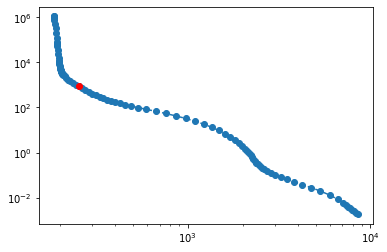

In [13]:
idx = 40
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

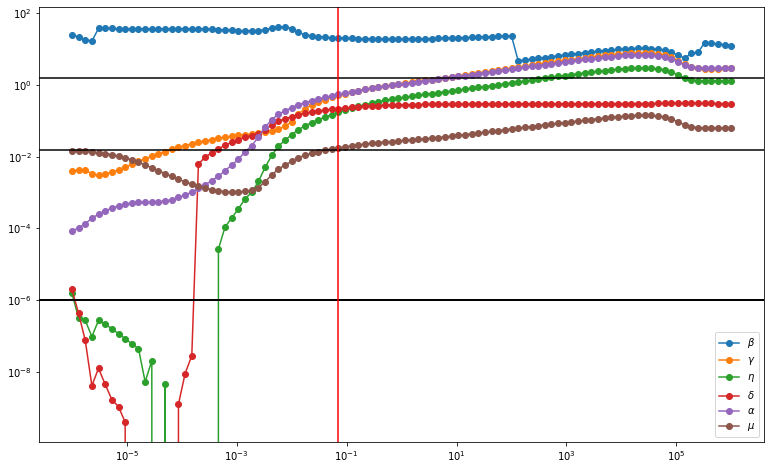

In [14]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

27.6879


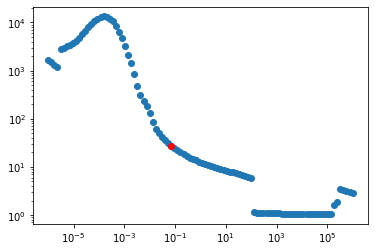

In [15]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

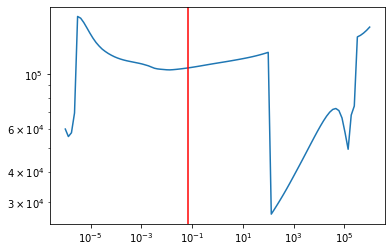

In [16]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(20.0737), DM(0.504672), DM(0.170006), DM(0.216893), DM(0.537494), DM(0.0175004))


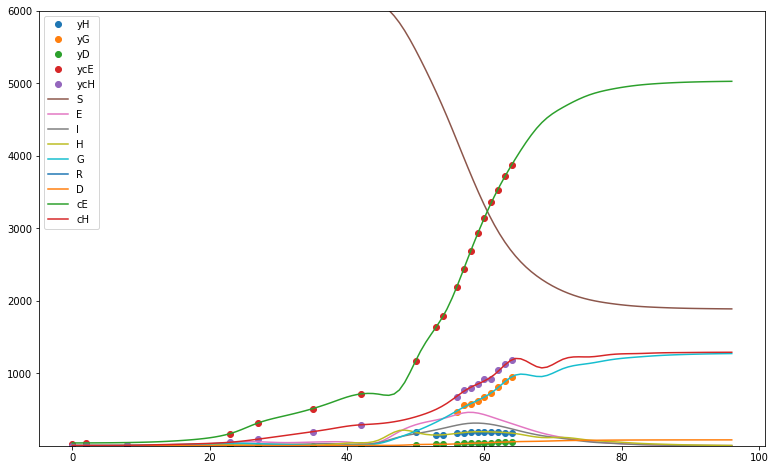

In [17]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 6000])
print(getp(sols[idx]['x']))

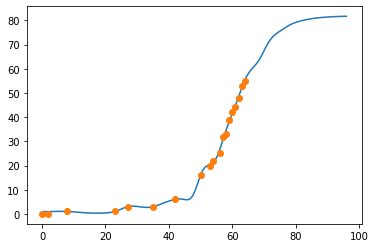

In [18]:
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')

(0, 6000)

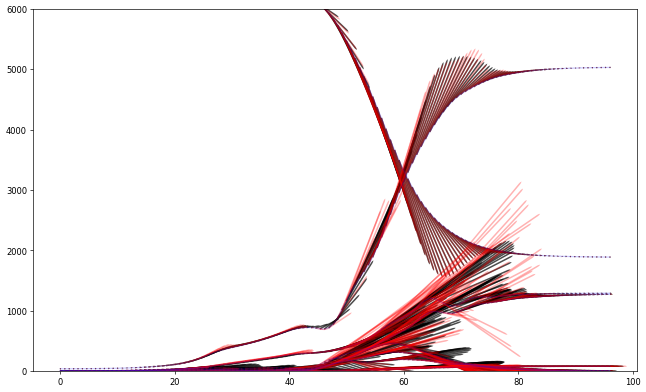

In [19]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

(0, 0.04)

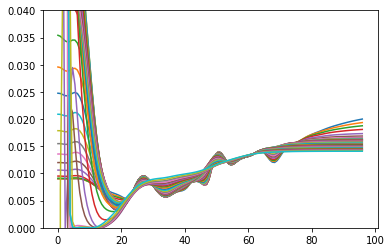

In [26]:
for i in range(30,70):
    plt.plot(model.observation_times, getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])
plt.ylim(0, 0.04)

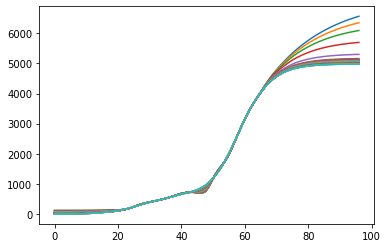

In [27]:
for i in range(30,70):
    plt.plot(model.observation_times, getx(sols[i]['x'])[-2])


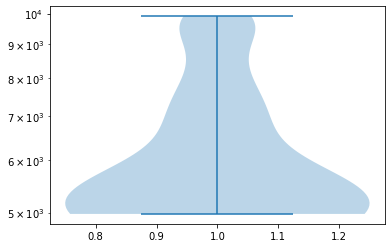

In [33]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
plt.yscale('log')

(0, 0.04)

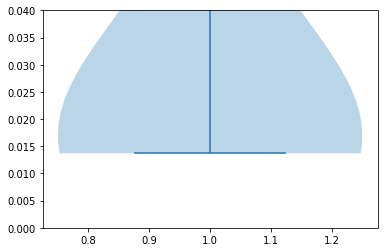

In [36]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
plt.ylim(0,0.04)